# DEMO: Predicting day-ahead energy consumption

In [1]:
from datetime import datetime as dt, timedelta
import pandas as pd
import numpy as np
import loadForecast as lf
import mpld3
mpld3.enable_notebook()
%matplotlib inline

In [2]:
f = 'data/NORTH.csv'
df = pd.read_csv(f)
all_X = lf.makeUsefulDf(df).to_numpy()
all_y = df['load'].to_numpy()
# convert boolean features into float32 variables
all_X = np.asarray(all_X).astype(np.float32)
print(all_X.shape, all_y.shape)
print(all_X, all_y)

(148920, 77) (148920,)
[[ 0.14616568  0.14616568  0.09402871 ...  0.         -1.504066
  -1.0962516 ]
 [ 0.14616568  0.14616568  0.09402871 ...  0.         -1.5061142
  -1.0963727 ]
 [ 0.14616568  0.14616568  0.09402871 ...  0.         -1.7679367
  -1.0905492 ]
 ...
 [-0.1487166  -0.23250529 -0.26818466 ...  0.         -0.8593938
  -0.92950296]
 [-0.28782824 -0.23250529 -0.26818466 ...  0.         -0.55310696
  -0.7604303 ]
 [-0.40761766 -0.23250529 -0.26818466 ...  0.         -0.7933047
  -0.8979182 ]] [995.29839211 981.19547682 971.30525685 ... 840.751157   836.086501
 826.962308  ]


In [3]:
predictions, accuracy = lf.neural_net_predictions(all_X, all_y)

Init Plugin
Init Graph Optimizer
Init Kernel
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-02-08 11:38:37.804542: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-08 11:38:37.804631: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-02-08 11:38:37.866193: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-08 11:38:37.866343: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-08 11:38:38.084317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:43:33.194348: I tensorflow/core/grappler/

Percent accuracy (MAPE). Train: 95.75923188995836.  Test: 95.9450144119571


<AxesSubplot:title={'center':'NCENT Texas 2018: prediction v. actual load'}>

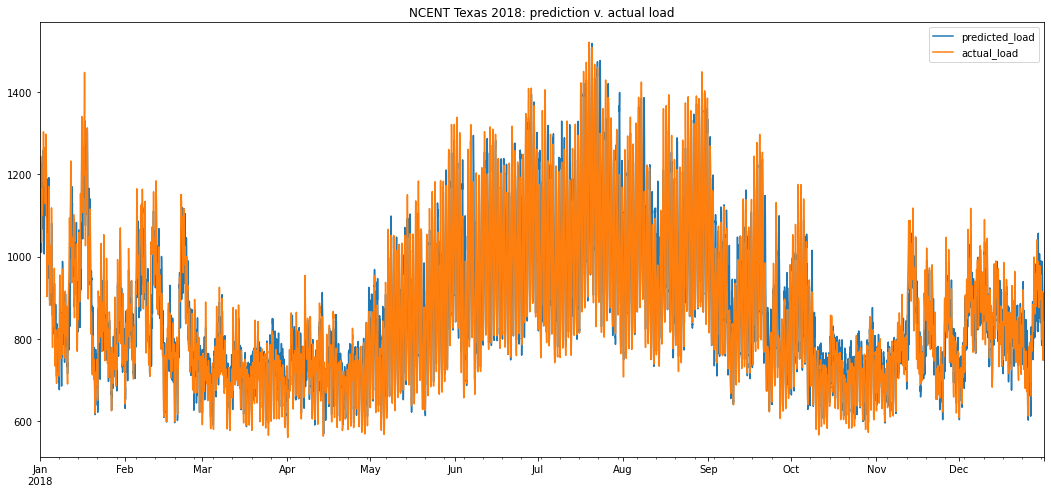

In [4]:
print('Percent accuracy (MAPE). Train: {}.  Test: {}'.format(100-accuracy['train'], 100-accuracy['test']))

df_r = pd.DataFrame()
df_r['predicted_load'] = predictions
df_r['actual_load'] = [float(f) for f in all_y[-8760:]]
df_r.index = [dt(2018, 1, 1, 0) + timedelta(hours=1)*i for i in range(8760)]
df_r.plot(figsize=(18, 8), title="NCENT Texas 2018: prediction v. actual load")

The new structure effectively combines 24 hourly models. But instead of calculating a single hour, we combine all weights into one flat, fully-connected dense layer (we settled on approx. 900 nodes). That layer is then fully connected to a 24-hour vector. 

In [7]:
def data_transform(data, timesteps, var='x'):
    m = []  
    for i in range(data.shape[0]-timesteps):  # starting index of a day sample
        m.append(data[i:i+timesteps].tolist())
    if var == 'x':
        t = np.zeros((len(m), len(m[0]), len(m[0][0])))
        for i, x in enumerate(m):  # x is each day sample
            for j, y in enumerate(x):  # y is each hour sample
                for k, z in enumerate(y):  # z is each feature
                    t[i, j, k] = z
    else:
        t = np.zeros((len(m), len(m[0])))
        for i, x in enumerate(m):
            for j, y in enumerate(x):
                t[i, j] = y
    return t

In [8]:
HOURS_AHEAD = 24
all_y_rnn = data_transform(all_y, HOURS_AHEAD, var='y')
all_X_rnn = data_transform(all_X, HOURS_AHEAD, var='x')
print(all_X_rnn.shape, all_y_rnn.shape)
print(all_X_rnn, all_y_rnn)

(148896, 24, 77) (148896, 24)
[[[ 1.46165684e-01  1.46165684e-01  9.40287113e-02 ...  0.00000000e+00
   -1.50406599e+00 -1.09625161e+00]
  [ 1.46165684e-01  1.46165684e-01  9.40287113e-02 ...  0.00000000e+00
   -1.50611424e+00 -1.09637272e+00]
  [ 1.46165684e-01  1.46165684e-01  9.40287113e-02 ...  0.00000000e+00
   -1.76793671e+00 -1.09054923e+00]
  ...
  [ 1.46165684e-01  1.46165684e-01  9.40287113e-02 ...  0.00000000e+00
   -1.31746829e+00 -1.07435441e+00]
  [ 1.46165684e-01  1.46165684e-01  9.40287113e-02 ...  0.00000000e+00
   -6.12047017e-01 -7.97462821e-01]
  [ 1.46165684e-01  1.46165684e-01  9.40287113e-02 ...  0.00000000e+00
   -1.32652414e+00 -1.07591307e+00]]

 [[ 1.46165684e-01  1.46165684e-01  9.40287113e-02 ...  0.00000000e+00
   -1.50611424e+00 -1.09637272e+00]
  [ 1.46165684e-01  1.46165684e-01  9.40287113e-02 ...  0.00000000e+00
   -1.76793671e+00 -1.09054923e+00]
  [ 1.46165684e-01  1.46165684e-01  9.40287113e-02 ...  0.00000000e+00
   -1.75126112e+00 -1.09218121e+00]

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow import keras

s = all_X.shape[1]
model_dayAhead = Sequential()
model_dayAhead.add(Dense(s, activation="relu", input_shape=(HOURS_AHEAD, s)))
model_dayAhead.add(Dense(s, activation="relu"))
model_dayAhead.add(Dense(s, activation="relu"))
model_dayAhead.add(Dense(s, activation="relu"))
model_dayAhead.add(Dense(s, activation="relu"))
model_dayAhead.add(Flatten())
model_dayAhead.add(Dense(s*HOURS_AHEAD//2, activation="relu"))
model_dayAhead.add(Dense(HOURS_AHEAD))

nadam = keras.optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
model_dayAhead.compile(optimizer=nadam, loss='mape', metrics=[keras.metrics.Accuracy()])

In [13]:
early_stop = keras.callbacks.EarlyStopping(monitor="mean_absolute_error", patience=20)

X_train_rnn, y_train_rnn = all_X_rnn[:-8760, :, :], all_y_rnn[:-8760, :]
X_test_rnn, y_test_rnn = all_X_rnn[-8760:, :, :], all_y_rnn[-8760:, :]
EPOCHS=10

history = model_dayAhead.fit(
    X_train_rnn,
    y_train_rnn,
    epochs=EPOCHS,
    verbose=0,
    callbacks=[early_stop],
)

predictions = np.array([])
for row in X_test_rnn:
    X_test_rnn_row = row.reshape(1, HOURS_AHEAD, s)
    yhat = model_dayAhead.predict(X_test_rnn_row, verbose=0)
    # print(yhat)
    predictions = np.append(predictions, yhat)

train = np.array([])
for row in X_train_rnn:
    X_train_rnn_row = row.reshape(1, HOURS_AHEAD, s)
    ytrainhat = model_dayAhead.predict(X_train_rnn_row, verbose=0)
    # print(yhat)
    train = np.append(train, ytrainhat)

In [19]:
print(predictions, train)
print(predictions.shape, train.shape)
print(y_test_rnn.shape, y_train_rnn.shape)

[971.36114502 967.22387695 955.40618896 ... 887.81109619 875.26281738
 835.74212646] [ 962.71398926  952.3862915   948.23565674 ... 1177.48156738 1155.47753906
 1096.8079834 ]
(210240,) (3363264,)
(8760, 24) (140136, 24)


In [18]:
def MAPE(predicted, true):
	assert len(predicted) == len(true)
	return sum([abs(x-y)/(y+1e-5) for x, y in zip(predicted, true)])/len(true)*100

In [ ]:
accuracy = {
    'test': MAPE(predictions, y_test_rnn),
    'train': MAPE(train, y_train_rnn)
}